In [15]:
import requests
import json
import pandas as pd
import os

In [14]:
path_to_survival_data = '/opt/gpudata/aartiv/qag/survival_plot_data'

In [ ]:
# this clinical data is just downloaded from the GDC portal
lgg_clinical = pd.read_csv(os.path.join(path_to_survival_data, 'clinical.tsv'), sep='\t')

In [3]:
all_lgg_status = lgg_clinical.groupby('cases.case_id')['demographic.vital_status'].unique()

In [4]:
all_lgg_status_df = all_lgg_status.to_frame().reset_index()
all_lgg_status_df['vital_status'] = all_lgg_status_df.apply(
    lambda x: x['demographic.vital_status'][0], axis=1
)

In [5]:
all_lgg_status_df.head()

,cases.case_id,demographic.vital_status,vital_status
0,001ad307-4ad3-4f1d-b2fc-efc032871c7e,[Alive],Alive
1,0061e9ef-df6a-414e-af64-c88f8192e2d3,[Dead],Dead
2,0073a136-d5f4-4fd6-88f9-711768f2abc6,[Alive],Alive
3,00b18ad6-ff70-41fe-8f4d-0763ac8f28b9,[Alive],Alive
4,010aac75-3bfe-4bf2-b866-af0f2d92f125,[Alive],Alive


In [6]:
# filter for get survival data for all TCGA-LGG patients

survival_filters_all = [
    {
        "op":"and",
        "content":[
            {
                "op":"=",
                "content":{
                    "field":"cases.project.project_id",
                    "value":"TCGA-LGG"
                }
            }
        ]
    }
]

In [7]:
def get_survival(survival_filter):

  survival_endpt = 'https://api.gdc.cancer.gov/analysis/survival'
  fields = [
      "case.project.project_id", "case.case_id"
  ]
  fields = ','.join(fields)
  params = {
      "filters": json.dumps(survival_filter),
      "fields": fields,
      "size": 1000
  }
  try:
    response = requests.get(survival_endpt, params=params)
  except Exception:
    pass
  return response

In [8]:
response_all = get_survival(survival_filter=survival_filters_all)
response_all_json = json.loads(response_all.content)


In [9]:
all_lgg_survival_df = pd.DataFrame([
    item
    for item in response_all_json['results'][0]['donors']
])

In [10]:
all_lgg_survival_df.head()

,time,censored,survivalEstimate,id,submitter_id,project_id
0,1.0,True,1.0,482d4078-7576-48cf-bf7c-29014935fd47,TCGA-HT-7472,TCGA-LGG
1,2.0,True,1.0,e117fcf4-2c01-4b4d-8faf-5de7d0e839f1,TCGA-HT-A5R9,TCGA-LGG
2,3.0,True,1.0,04d56bed-98fb-45eb-8c90-95e69264dfe2,TCGA-HT-A5RB,TCGA-LGG
3,3.0,True,1.0,81076cfb-f9d7-4add-b696-6eab0bad7945,TCGA-HT-8015,TCGA-LGG
4,3.0,True,1.0,3f36cd97-eb22-47de-b447-5c96378e4a2b,TCGA-HT-7687,TCGA-LGG


In [11]:
lgg_clinical_survival = pd.merge(
    left=all_lgg_survival_df,
    right=all_lgg_status_df,
    left_on=['id'],
    right_on=['cases.case_id'],
    how='left'
)

In [12]:
lgg_clinical_survival.head()

,time,censored,survivalEstimate,id,submitter_id,project_id,cases.case_id,demographic.vital_status,vital_status
0,1.0,True,1.0,482d4078-7576-48cf-bf7c-29014935fd47,TCGA-HT-7472,TCGA-LGG,482d4078-7576-48cf-bf7c-29014935fd47,[Alive],Alive
1,2.0,True,1.0,e117fcf4-2c01-4b4d-8faf-5de7d0e839f1,TCGA-HT-A5R9,TCGA-LGG,e117fcf4-2c01-4b4d-8faf-5de7d0e839f1,[Alive],Alive
2,3.0,True,1.0,04d56bed-98fb-45eb-8c90-95e69264dfe2,TCGA-HT-A5RB,TCGA-LGG,04d56bed-98fb-45eb-8c90-95e69264dfe2,[Alive],Alive
3,3.0,True,1.0,81076cfb-f9d7-4add-b696-6eab0bad7945,TCGA-HT-8015,TCGA-LGG,81076cfb-f9d7-4add-b696-6eab0bad7945,[Alive],Alive
4,3.0,True,1.0,3f36cd97-eb22-47de-b447-5c96378e4a2b,TCGA-HT-7687,TCGA-LGG,3f36cd97-eb22-47de-b447-5c96378e4a2b,[Alive],Alive


In [16]:
# survival data in TSV format downloaded from GDC portal 
# for double mutants and IDH1_R132H single mutants
# cohorts were created for double mutants (using case_ids from GDC-QAG) and single mutant on the portal
# survival plot inspected in portal and TSV downloaded
survival_df = pd.read_csv(os.path.join(path_to_survival_data,'survival-plot.tsv'), sep='\t')

In [ ]:
# rename S1 and S2 to something meaningful 
survival_df.replace('S1', 'double_mutant', inplace=True)
survival_df.replace('S2', 'IDH1_R132H', inplace=True)

In [18]:
# join single mutation survival df with clinical data
survival_with_status = pd.merge(
    left=survival_df,
    right=lgg_clinical_survival,
    on=['id', 'censored', 'survivalEstimate', 'submitter_id', 'project_id'],
    how='left'
)

In [19]:
survival_with_status['boolean_status'] = survival_with_status.apply(
    lambda x: False if x['vital_status'] == 'Alive' else True, axis=1
)

In [20]:
survival_with_status.head()

,id,time (days),time (months),time (years),censored,survivalEstimate,submitter_id,project_id,label,time,cases.case_id,demographic.vital_status,vital_status,boolean_status
0,618f2aa7-d1b6-430d-a157-d3d956edefbe,4,0,0.0,True,1.0,TCGA-HT-A5R5,TCGA-LGG,double_mutant,4.0,618f2aa7-d1b6-430d-a157-d3d956edefbe,[Alive],Alive,False
1,e7fdf164-a85d-4ff5-9676-d2215ca35403,153,5,0.4,True,1.0,TCGA-HT-7601,TCGA-LGG,double_mutant,NaN,NaN,NaN,NaN,True
2,d766c3af-f0b3-4791-a754-d6546d370f8f,190,6,0.5,True,1.0,TCGA-HT-8105,TCGA-LGG,double_mutant,NaN,NaN,NaN,NaN,True
3,e326c1dd-2ef8-431b-a657-440aa3f35ff3,207,7,0.6,True,1.0,TCGA-DU-5855,TCGA-LGG,double_mutant,NaN,NaN,NaN,NaN,True
4,c85fa637-941a-4a9a-8029-f5b44f3da430,242,8,0.7,True,1.0,TCGA-P5-A5F2,TCGA-LGG,double_mutant,NaN,NaN,NaN,NaN,True


In [21]:
# survival data in TSV format for WT and TP53 R273C single mutants downloaded from GDC portal
# after inspecting survival plots
survival_data_tp53_wt = pd.read_csv( os.path.join(path_to_survival_data, 'survival-plot-2.tsv'), sep='\t')

In [22]:
survival_data_tp53_wt.replace('S1', 'WT', inplace=True)
survival_data_tp53_wt.replace('S2', 'TP53_R273C', inplace=True)

In [23]:
survival_tp53_with_status = pd.merge(
    left=survival_data_tp53_wt,
    right=lgg_clinical_survival,
    on=['id', 'censored', 'survivalEstimate', 'submitter_id', 'project_id'],
    how='left'
)

In [24]:
survival_tp53_with_status['boolean_status'] = survival_tp53_with_status.apply(
    lambda x: False if x['vital_status'] == 'Alive' else True, axis=1
)

In [26]:
survival_df = pd.concat([
    survival_tp53_with_status,
    survival_with_status
])

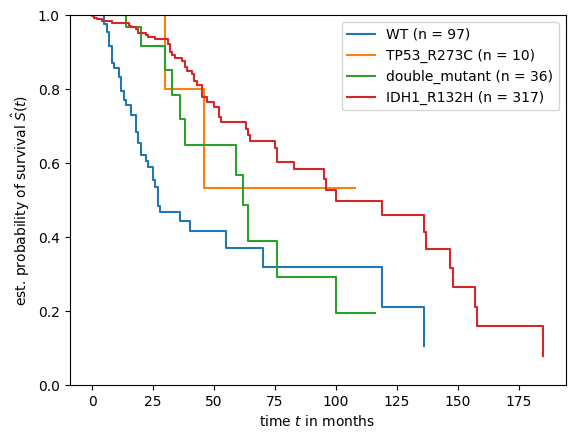

In [27]:
from matplotlib import pyplot as plt

for value in survival_df['label'].unique():
    mask = survival_df['label'] == value
    plt.step(
        survival_df['time (months)'][mask], 
        survival_df['survivalEstimate'][mask], 
        where="post", 
        label=f"{value} (n = {mask.sum()})"
    )

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ in months")
plt.legend(loc="best")
plt.savefig('../figs/S4.png', bbox_inches='tight', dpi=300)